# titanic
---

## kaggle api
- downloads datasets
```bash
kaggle competitions download -c {compe-name}
```

- downloads notebook
```bash
kaggle kernels pull {user-name}/{notebook-name}
```

In [1]:
# set const value
# default: wd = kaggle/
import os
wd = os.getcwd()

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(wd+'/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/jovyan/work/input/titanic.zip
/home/jovyan/work/input/gender_submission.csv
/home/jovyan/work/input/test.csv
/home/jovyan/work/input/train.csv


In [3]:
# imports 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# plt params. set in below
change_dct = {
    'font.size': 20,
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'stix',
    "figure.figsize": [16, 8],
    'figure.facecolor': (0, 0, 0, 0),
    'axes.facecolor': (0, 0, 0, 0),
    'savefig.facecolor': (0, 0, 0, 0),
    'figure.subplot.left': 0.11,
    'figure.subplot.right': 0.90,
    'figure.subplot.top': 0.95,
    'figure.subplot.bottom': 0.08,
    'figure.subplot.hspace': 0.1,
    'savefig.format': 'pdf',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.top": True,
    "ytick.right": True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'legend.edgecolor': 'black',
    'legend.facecolor': 'white',
    'legend.framealpha': 1,
}
# set params on plt .rcParams
for key, val in change_dct.items():
    plt.rcParams[key] = val

In [7]:
train = pd.read_csv(wd+'/input/train.csv')
test = pd.read_csv(wd+'/input/test.csv')
gender = pd.read_csv(wd+'/input/gender_submission.csv')

# About Data

## Data Dictionary
| Variable | Definition                                 | Key                                            | 
| -------- | ------------------------------------------ | ---------------------------------------------- | 
| survival | Survival                                   | 0 = No, 1 = Yes                                | 
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | 
| sex      | Sex                                        |                                                | 
| Age      | Age in years                               |                                                | 
| sibsp    | # of siblings / spouses aboard the Titanic |                                                | 
| parch    | # of parents / children aboard the Titanic |                                                | 
| ticket   | Ticket number                              |                                                | 
| fare     | Passenger fare                             |                                                | 
| cabin    | Cabin number                               |                                                | 
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | 

## Variable Notes
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

# EDA and preprocessing

In [8]:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_tmp = train.copy()

## - Sex -->> 1:male, 0:female
train_tmp['Sex'] = train_tmp['Sex'].map({'male':1, 'female':0})

## - Ticket -->> Number after a space
import re
Ticket_num = train_tmp['Ticket'].apply(lambda x: re.sub('.* ', '', x))
Ticket_num = Ticket_num.apply(lambda x: re.sub(' ', '', x))
Ticket_num = Ticket_num.apply(lambda x: re.sub('\.', '', x))
Ticket_num = Ticket_num.apply(lambda x: re.sub('LINE', '', x))
Ticket_num = Ticket_num.apply(lambda x: re.sub('/', '', x))
train_tmp['Ticket'] = Ticket_num.apply(lambda x: np.nan if len(x)==0 else x).astype(float)

## - Cabin -->> the first character of a string && get_dummy()
train_tmp['Cabin'] = train_tmp['Cabin'].apply(lambda x: str(x)[0] if str(x)!='nan' else np.nan)

## - Embarked -->> get_dummy()


train_tmp.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,21171.0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,17599.0,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,3101282.0,7.9250,NaN,S


/tmp/ipykernel_3007/1600671986.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_tmp.hist(ax=ax, bins=20)
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


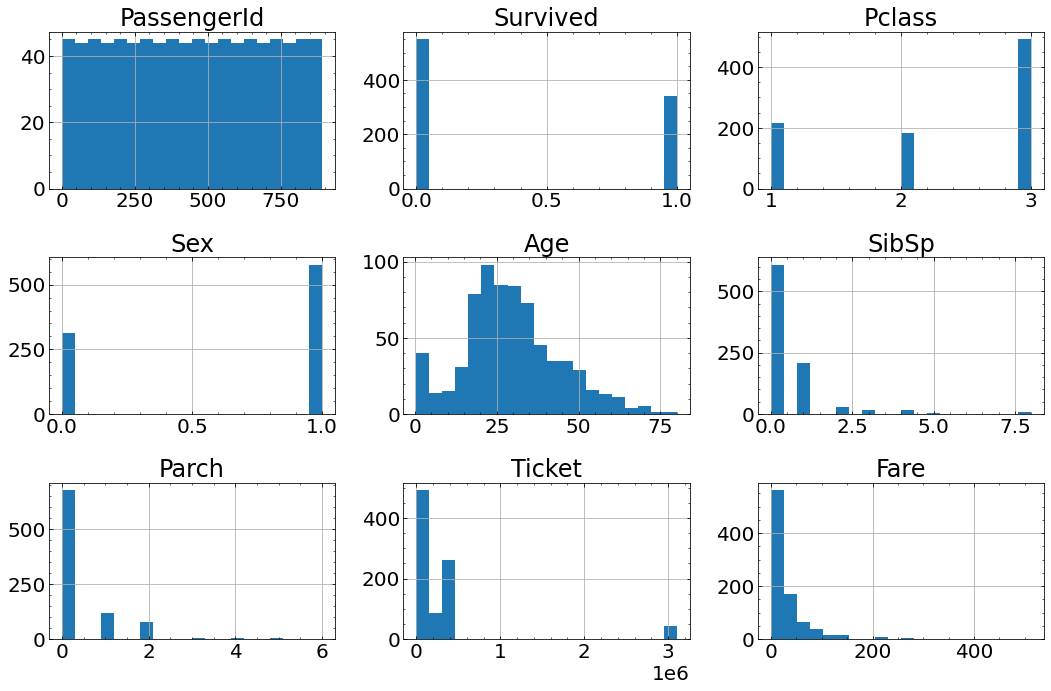

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

train_tmp.hist(ax=ax, bins=20)

plt.tight_layout()

In [9]:
# train_tmp.query('Ticket <= 1000000')['Ticket'].hist()
# train_tmp.query('Ticket >= 3000000')
## flg (1 if Ticket >= 3000000)
train_tmp['Ticket'] = train_tmp['Ticket'].apply(lambda x: 1 if x>=3000000 else 0)

/tmp/ipykernel_22947/1600671986.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_tmp.hist(ax=ax, bins=20)
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


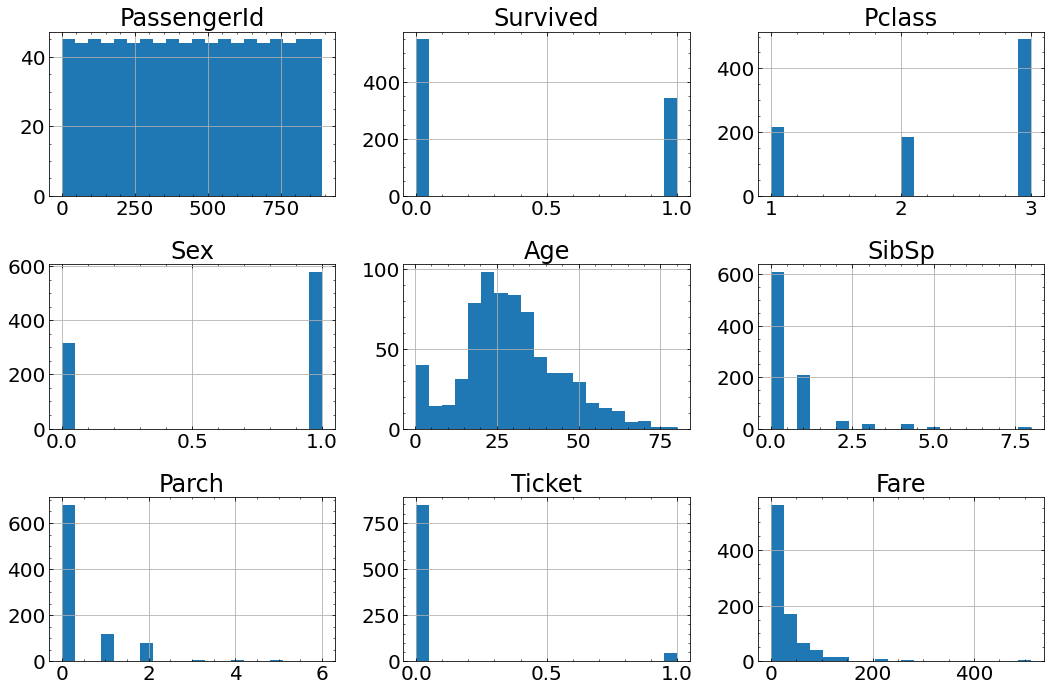

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

train_tmp.hist(ax=ax, bins=20)

plt.tight_layout()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

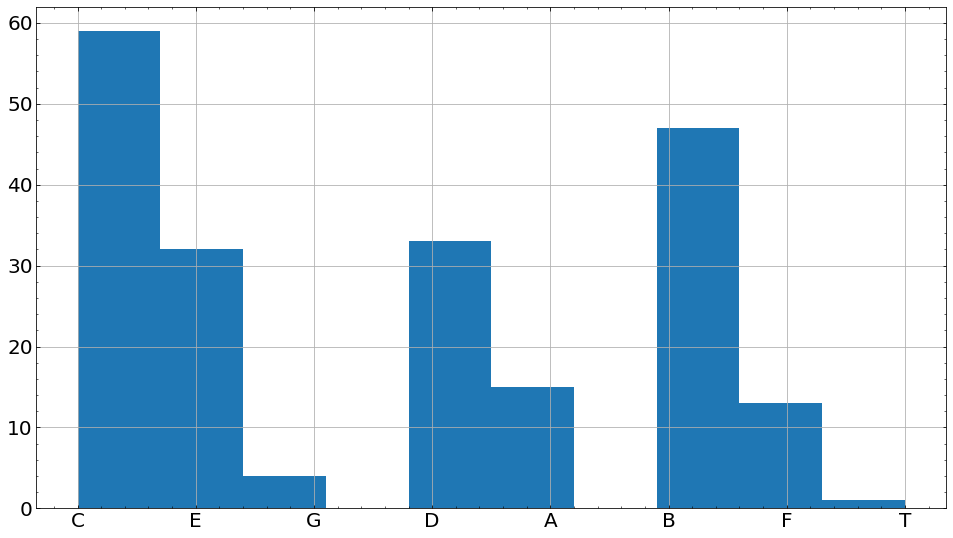

In [17]:
t = train_tmp['Cabin'].value_counts()
display(t)
train_tmp['Cabin'].hist()
plt.show() 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:>

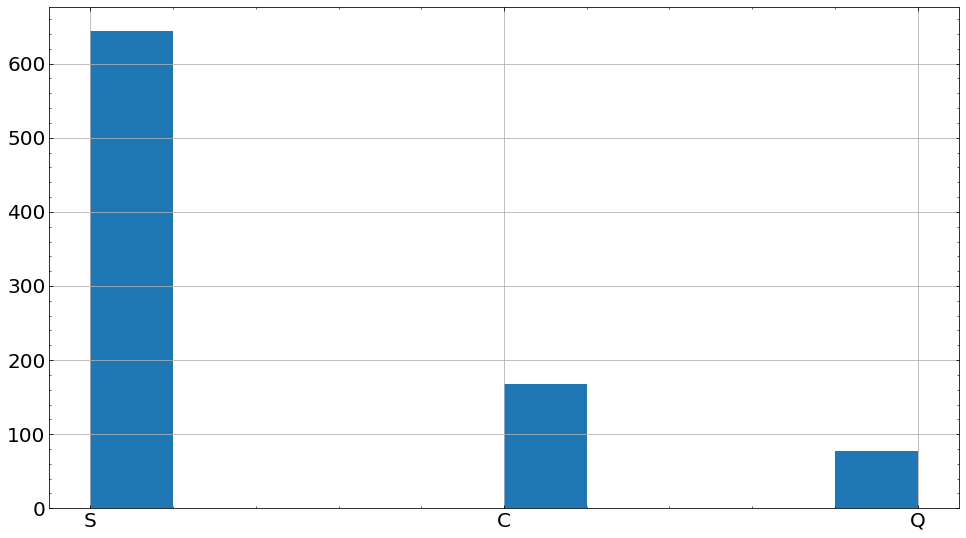

In [18]:
t = train_tmp['Embarked'].value_counts()
display(t)
train_tmp['Embarked'].hist()

In [19]:
train_tmp = pd.get_dummies(train_tmp, columns=['Cabin', 'Embarked'])

In [20]:
train_tmp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,0,71.2833,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,1,7.9250,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0,53.1000,...,0,1,0,0,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0,8.0500,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,0,13.0000,...,0,0,0,0,0,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,0,30.0000,...,1,0,0,0,0,0,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,0,23.4500,...,0,0,0,0,0,0,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,0,30.0000,...,0,1,0,0,0,0,0,1,0,0


In [21]:
train_tmp.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036847,-0.057527,-0.001652,-0.017783,0.012658,-0.003256,0.069552,-0.040957,0.022828,0.042351,-0.035772,-0.060049,-0.013814,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,-0.052074,0.257307,0.022287,0.175095,0.114652,0.150716,0.145321,0.057935,0.016040,-0.026456,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,0.188577,-0.549500,-0.204934,-0.369572,-0.417048,-0.278690,-0.230091,0.011063,0.055561,-0.052496,-0.243292,0.221009,0.081720
Sex,0.042939,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,0.059704,-0.182333,0.078271,-0.109689,-0.058649,-0.079248,-0.047003,-0.008202,-0.091031,0.024728,-0.082853,-0.074115,0.125722
Age,0.036847,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,-0.076008,0.096067,0.136309,0.093914,0.122041,0.136975,0.121440,-0.083970,-0.077296,0.039474,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.065743,0.159651,-0.046266,-0.034538,0.029251,-0.017575,-0.036865,0.001706,-0.001402,-0.015907,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,-0.024370,0.216225,-0.040325,0.056498,0.030736,-0.019125,-0.016554,0.023694,0.072388,-0.015878,-0.011069,-0.081228,0.063036
Ticket,-0.017783,-0.052074,0.188577,0.059704,-0.076008,0.065743,-0.024370,1.000000,-0.089064,-0.029825,-0.053785,-0.060694,-0.044699,-0.043991,-0.027734,-0.015306,-0.007640,-0.109868,-0.070100,0.141153
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,-0.089064,1.000000,0.019549,0.386297,0.364318,0.098878,0.053717,-0.033093,-0.025180,0.002224,0.269335,-0.117216,-0.166603
Cabin_A,-0.003256,0.022287,-0.204934,0.078271,0.136309,-0.046266,-0.040325,-0.029825,0.019549,1.000000,-0.030880,-0.034846,-0.025663,-0.025256,-0.015923,-0.008787,-0.004386,0.093040,-0.040246,-0.055383


<AxesSubplot:>

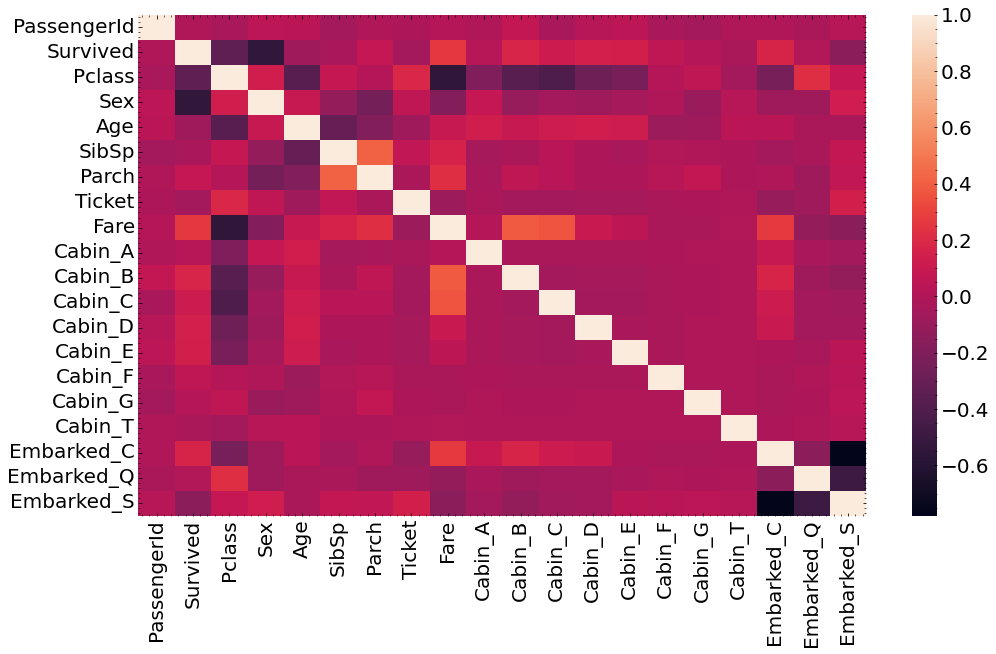

In [22]:
sns.heatmap(train_tmp.corr())

## Based on the results of eda, perform the following preprocessing on the data
- outliers do not be processed.
- name do not be used as a feature
- I want to use Cabin because it doesn't have a low correlation, but I can't because there are too many missing pieces.
    - You can use Fare or something like that to estimate and fillna, but not in this case because it might be too complicated.
- Embarked is droped because it has fewer deficiencies.
- Standardize on a train-fit scaler for all features

| Variable | Definition                                 | preprocess                                     | 
| -------- | ------------------------------------------ | ---------------------------------------------- | 
| survival | Survival                                   | ##### target #####                             | 
| pclass   | Ticket class                               | get_dummies(drop_first=True)                   | 
| sex      | Sex                                        | map({'male':1, 'female':0}                     | 
| Age      | Age in years                               | sex, pcalss, parch, ごとの平均で fillna()      | 
| sibsp    | # of siblings / spouses aboard the Titanic |                                                | 
| parch    | # of parents / children aboard the Titanic |                                                | 
| ticket   | Ticket number                              | 番号部分が30000以上なら1っていうフラグ変数にする | 
| fare     | Passenger fare                             |                                                | 
| embarked | Port of Embarkation                        | dropna() -->> C, Q, S get_dummy(drop_first=True) | 

In [111]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [129]:
def preprocess_data(df):
    res_df = df.copy()

    res_df.drop('Cabin', axis=1, inplace=True)
    res_df.drop('Name', axis=1, inplace=True)

    res_df['Sex'] = res_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

    s = res_df.groupby(['Sex', 'Pclass', 'Parch'])['Age'].transform('mean')
    res_df['Age'] = res_df['Age'].fillna(value=s)
    t = res_df.groupby(['Sex', 'Pclass'])['Age'].transform('mean')
    res_df['Age'] = res_df['Age'].fillna(value=t)

    r = res_df.groupby(['Sex', 'Pclass'])['Fare'].transform('mean')
    res_df['Fare'] = res_df['Fare'].fillna(value=r)

    Ticket_num = res_df['Ticket'].apply(lambda x: re.sub('.* ', '', x))
    Ticket_num = Ticket_num.apply(lambda x: re.sub(' ', '', x))
    Ticket_num = Ticket_num.apply(lambda x: re.sub('\.', '', x))
    Ticket_num = Ticket_num.apply(lambda x: re.sub('LINE', '', x))
    Ticket_num = Ticket_num.apply(lambda x: re.sub('/', '', x))
    Ticket_num = Ticket_num.apply(lambda x: np.nan if len(x)==0 else x).astype(float)
    res_df['Ticket'] = Ticket_num.apply(lambda x: 1 if x>=3000000 else 0)

    res_df = pd.get_dummies(res_df, drop_first=True)

    res_df['Pclass_1'] = res_df['Pclass'].apply(lambda x: 1 if x==1 else 0)
    res_df['Pclass_2'] = res_df['Pclass'].apply(lambda x: 1 if x==2 else 0)
    res_df.drop('Pclass', axis=1, inplace=True)

    return res_df

# modeling
use StackingClassifier from sklearn.ensemble
- LogisticRegression
- lightGBM
- RGFClassifier
- ExtraTreesClassifier
- RandomForestClassifier
- KNeighborsClassifier

In [130]:
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat(
    [train, test], 
    axis=0
)
df = preprocess_data(df)
train_m = df.query('is_test == 0').drop('is_test', axis=1)
test_m = df.query('is_test == 1').drop(['is_test', 'Survived'], axis=1)

In [132]:
train_x = train_m.drop(['PassengerId', 'Survived'], axis=1)
train_y = train_m['Survived']
test_x = test_m.drop('PassengerId', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)

train_x_std = scaler.transform(train_x)
test_x_std = scaler.transform(test_x)

In [133]:
X_train, X_val, y_train, y_val = train_test_split(train_x_std, train_y, test_size=0.2, random_state=42)

In [134]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from rgf.sklearn import RGFClassifier

lgbm_params = {
        'boosting': 'dart', 
        'application': 'binary',
        'learning_rate': 0.05,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'num_leaves': 41,
        'metric': 'binary_logloss',
        'drop_rate': 0.15
}
rgf_params = {'algorithm': 'RGF_Sib', 'loss': 'Log'}
et_params = {'n_estimators': 100, 'max_features': 0.5, 'max_depth': 18, 'min_samples_leaf': 4, 'n_jobs': -1}
rf_params = {'n_estimators': 125, 'max_features': 0.2, 'max_depth': 25, 'min_samples_leaf': 4, 'n_jobs': -1}

final_estimator = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        ('lr', LogisticRegression())
    ],
    final_estimator=LogisticRegression()
)

clf = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        #('nn', KerasClassifier(build_fn=build_fn, **keras_params)),
        ('rgf', RGFClassifier(**rgf_params)),
        ('et', ExtraTreesClassifier(**et_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier())
    ],
    final_estimator=final_estimator
)

In [135]:
clf.fit(X_train, y_train)
prediction = clf.predict(X_val)
accuracy_score(y_val, prediction)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_s

0.8044692737430168

In [136]:
predict = clf.predict(test_x_std)

output = pd.DataFrame({'PassengerId': test_m.PassengerId, 'Survived': predict})
output.to_csv(wd+'output/my_submission.csv', index=False)
print("Submission saved")

Submission saved
